# Exploring Tesser Data Using Succersor Representation  Models

In [1]:
# main_tesser
import numpy as np
import scipy.spatial.distance as spsd
from scipy.signal import find_peaks_cwt as find_peak
import numpy.linalg as la
import matplotlib.pyplot as plt
import pandas as pd
import make_data as mkdt
import learning as ln
import sys
sys.path.append ('/home/rodrigo/Documents/preston_labs/tesser_successor/')

from tesser import network

path = '/home/rodrigo/Dropbox/tesser_successor/Data/'

data, dl, induc_data, induc_list = mkdt.get_data(path)

In [2]:
print("There are %d subjects in this data set"% (len(induc_list)))
print()
for x in range(len(induc_list)):
    print('Subject %s is named %s'% (x,induc_list[x][:17]))

There are 37 subjects in this data set

Subject 0 is named tesserScan_100_B/
Subject 1 is named tesserScan_101_E/
Subject 2 is named tesserScan_102_S/
Subject 3 is named tesserScan_103_S/
Subject 4 is named tesserScan_104_J/
Subject 5 is named tesserScan_105_M/
Subject 6 is named tesserScan_106_H/
Subject 7 is named tesserScan_107_B/
Subject 8 is named tesserScan_108_M/
Subject 9 is named tesserScan_109_M/
Subject 10 is named tesserScan_110_AC
Subject 11 is named tesserScan_111_YM
Subject 12 is named tesserScan_112_JG
Subject 13 is named tesserScan_113_N/
Subject 14 is named tesserScan_114_SS
Subject 15 is named tesserScan_115_JG
Subject 16 is named tesserScan_116_GS
Subject 17 is named tesserScan_117_DC
Subject 18 is named tesserScan_119_SS
Subject 19 is named tesserScan_120_AS
Subject 20 is named tesserScan_121_TM
Subject 21 is named tesserScan_122_GL
Subject 22 is named tesserScan_123_AC
Subject 23 is named tesserScan_124_LO
Subject 24 is named tesserScan_125_DS
Subject 25 is named 

In [3]:
def fix(matrix):
    new_matrix = matrix
    new_matrix[new_matrix == 0] = 0.0000001
    return new_matrix

def trans(matrix):
    m = np.transpose(matrix)
    return m

def make_M_Matrix(dir,gamma, alpha, M):  
    envsteps= ln.make_envstep(dir)
    M  = ln.SRclass_nathum_exp1(envsteps, gamma, alpha, M) #W, mem, total_episodes
    return M

def initial_subj_run(num):
    count = []
    for i in range(0, len(dl), 11):
        count.append(i)
    return count[num]


In [4]:

def main_opt (option, subj_num, gamma, alpha):
    
    figsize=(70,30)
    size = 50    
    fig, axs = plt.subplots(2, 6, figsize=figsize ,sharex='col', sharey='row')
    plt.subplots_adjust(hspace=0.5)
    
    a = initial_subj_run(subj_num)
    b = str(subj_num)


    # This option allows the SR matrix to persist across all runs from Part 1 and Part 2
    #     without ever resetting.
    if option == 'persist':
        plt.suptitle("Persistent Learning: Subject " + b + " Name: " + dl[a][:17] +  "\n", size = 80)
        M = np.zeros([21,21])
        for run in range(0,11):
            
            if run < 5:
                M += make_M_Matrix(a + run, gamma, alpha, np.copy(M))
                axs[0, run].matshow(M, cmap='viridis', vmin=0, vmax=1)
                axs[0, run].set_title(dl[a + run][-15:-4]+ "\n", size=size)
 
            else:    
                M += make_M_Matrix(a + run, gamma, alpha, np.copy(M))
                axs[1, run -5].matshow(M, cmap='viridis', vmin=0, vmax=1)
                axs[1, run -5].set_title(dl[a + run][-15:-4]+ "\n", size=size)

        fig.delaxes(axs[0][5])
        return plt.show()

    # This option allows the SR matrix to persist in Part 1 and Part 2, but resets it between them.
    if option == 'reset':
        plt.suptitle("Reset Learning: Subject " + b + " Name: " + dl[a][:17] +  "\n", size = 80)
        M = np.zeros ([21,21])
        is_reset = False
        for run in range(0,11):
            if not is_reset and run >= 5:
                M = np.zeros ([21,21])
                is_reset = True
            if run < 5:
                M += make_M_Matrix(a + run, gamma, alpha, np.copy(M))
                axs[0, run].matshow(M, cmap='viridis', vmin=0, vmax=1)
                axs[0, run].set_title(dl[a + run][-15:-4]+ "\n", size=size)
            else:    
                M += make_M_Matrix(a + run, gamma, alpha, np.copy(M))
                axs[1, run -5].matshow(M, cmap='viridis', vmin=0, vmax=1)
                axs[1, run -5].set_title(dl[a + run][-15:-4]+ "\n", size=size)
        fig.delaxes(axs[0][5])
        return plt.show()

    # This option resets the SR matrix between each run.
    if option == 'independent':
        plt.suptitle("Independent Learning: Subject " + b + " Name: " + dl[a][:17] +  "\n", size = 80)
        M = np.zeros ([21,21])
        for run in range(0,11):
            if run < 5:
                M = make_M_Matrix(a + run, gamma, alpha, M)
                axs[0, run].matshow(M, cmap='viridis', vmin=0, vmax=1)
                axs[0, run].set_title(dl[a + run][-15:-4]+ "\n", size=size)
                M = np.zeros ([21,21])
            else:    
                M = make_M_Matrix(a + run, gamma, alpha, M)
                axs[1, run -5].matshow(M, cmap='viridis', vmin=0, vmax=1)
                axs[1, run -5].set_title(dl[a + run][-15:-4]+ "\n", size=size)
                M = np.zeros ([21,21])
                
        fig.delaxes(axs[0][5])
        return plt.show()

    # This option forces the SR matrix to persist across all runs, but instead of plotting the SR matrix
    #     after each run, it plots the changes made to it after learning each object sequence.
    if option == 'track changes':
        plt.suptitle("Learning w/ Changes: Subject " + b + " Name: " + dl[a][:17] +  "\n", size = 80)
        M = np.zeros([21,21])

        for run in range(0,11):
            if run < 5:
                envsteps = ln.make_envstep(a + run)
                M_new = np.copy(M)
                M_new = ln.SRclass_nathum_exp1(envsteps, gamma, alpha, M_new)
                axs[0, run].matshow(M_new -M, cmap='viridis', vmin=0, vmax=1)
                axs[0, run].set_title(dl[a + run][-15:-4]+ "\n", size=size)
                M = M_new
            else:
                envsteps = ln.make_envstep(a + run)
                M_new = np.copy(M)
                M_new = ln.SRclass_nathum_exp1(envsteps, gamma, alpha, M_new)
                axs[1, run -5].matshow(M_new -M, cmap='viridis', vmin=0, vmax=1)
                axs[1, run -5].set_title(dl[a + run][-15:-4]+ "\n", size=size)
                M = M_new

        fig.delaxes(axs[0][5])
        return plt.show()




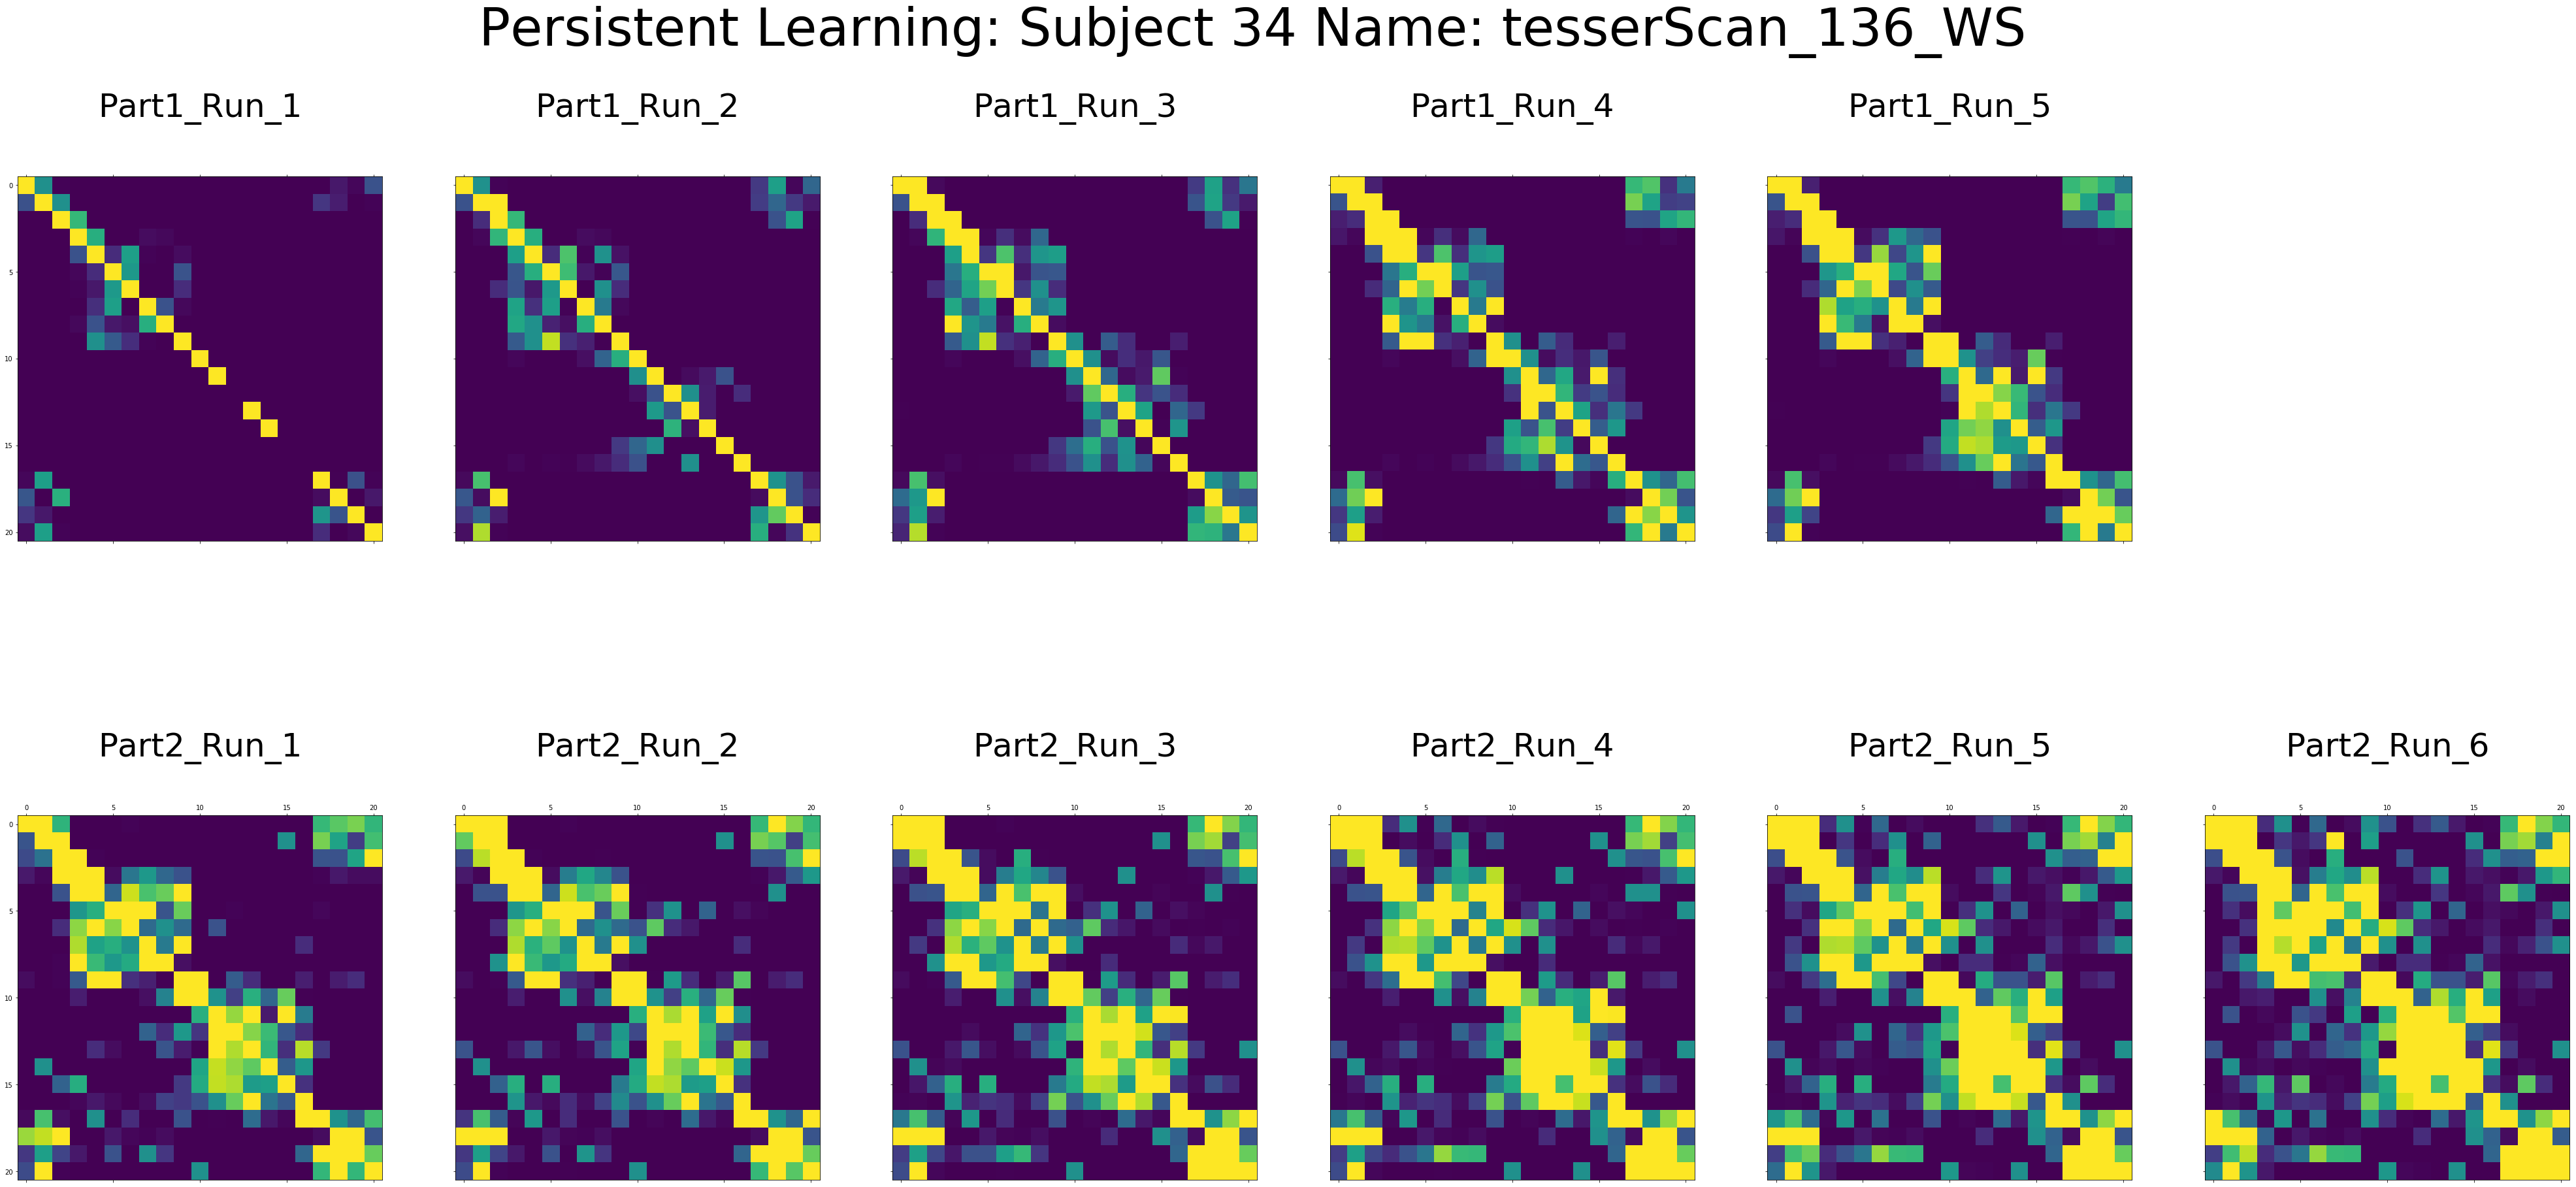

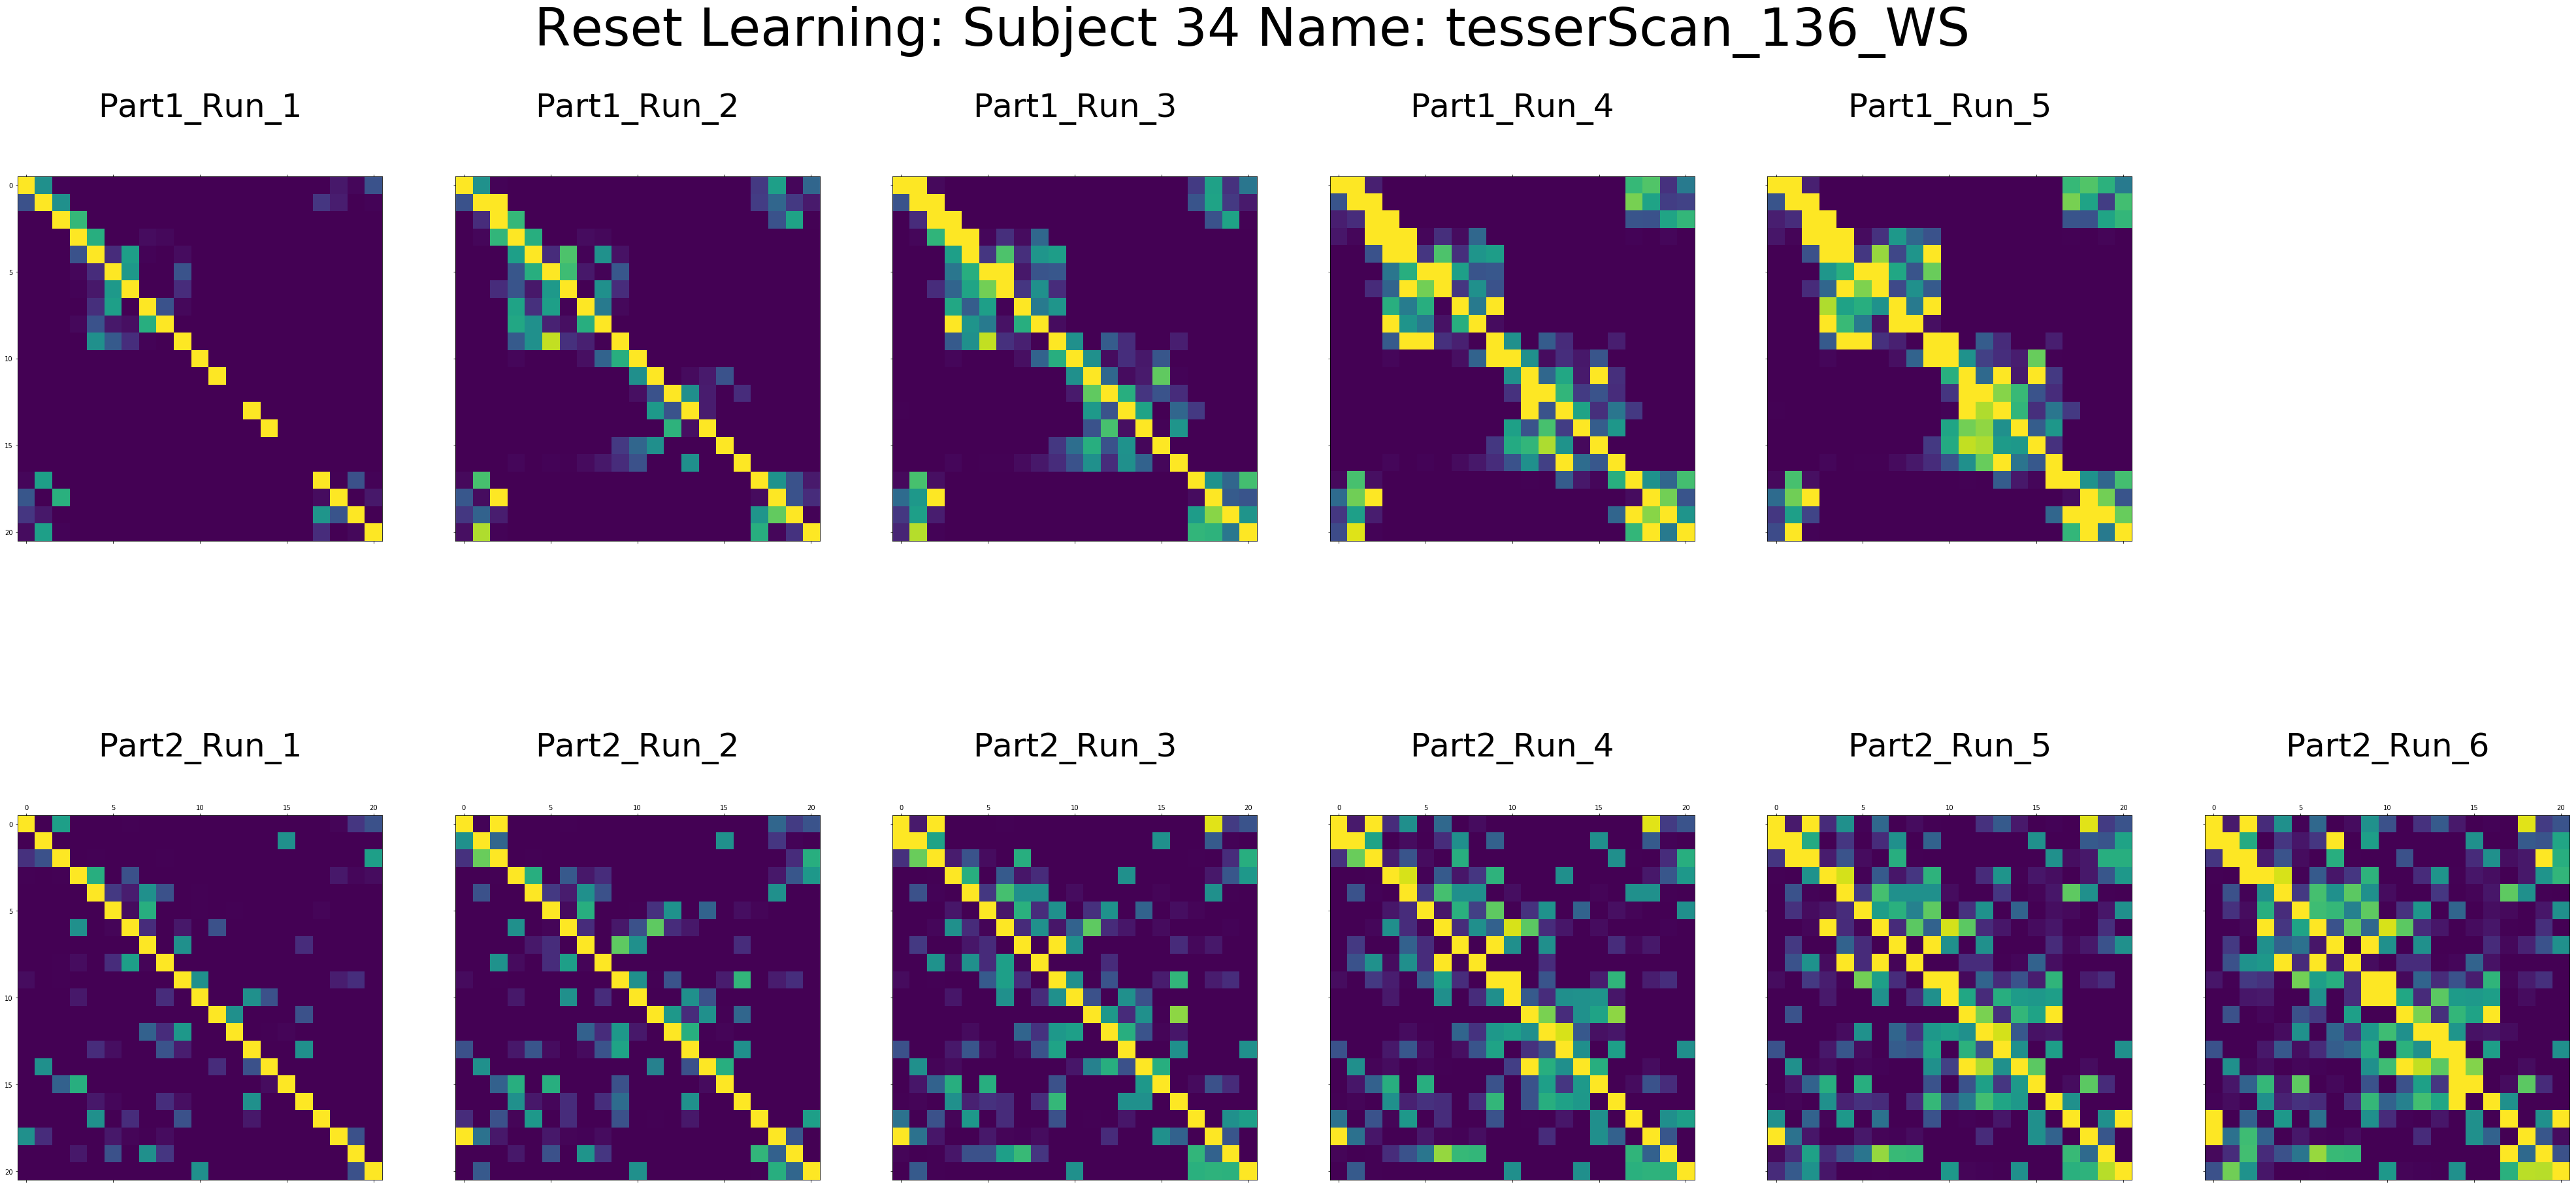

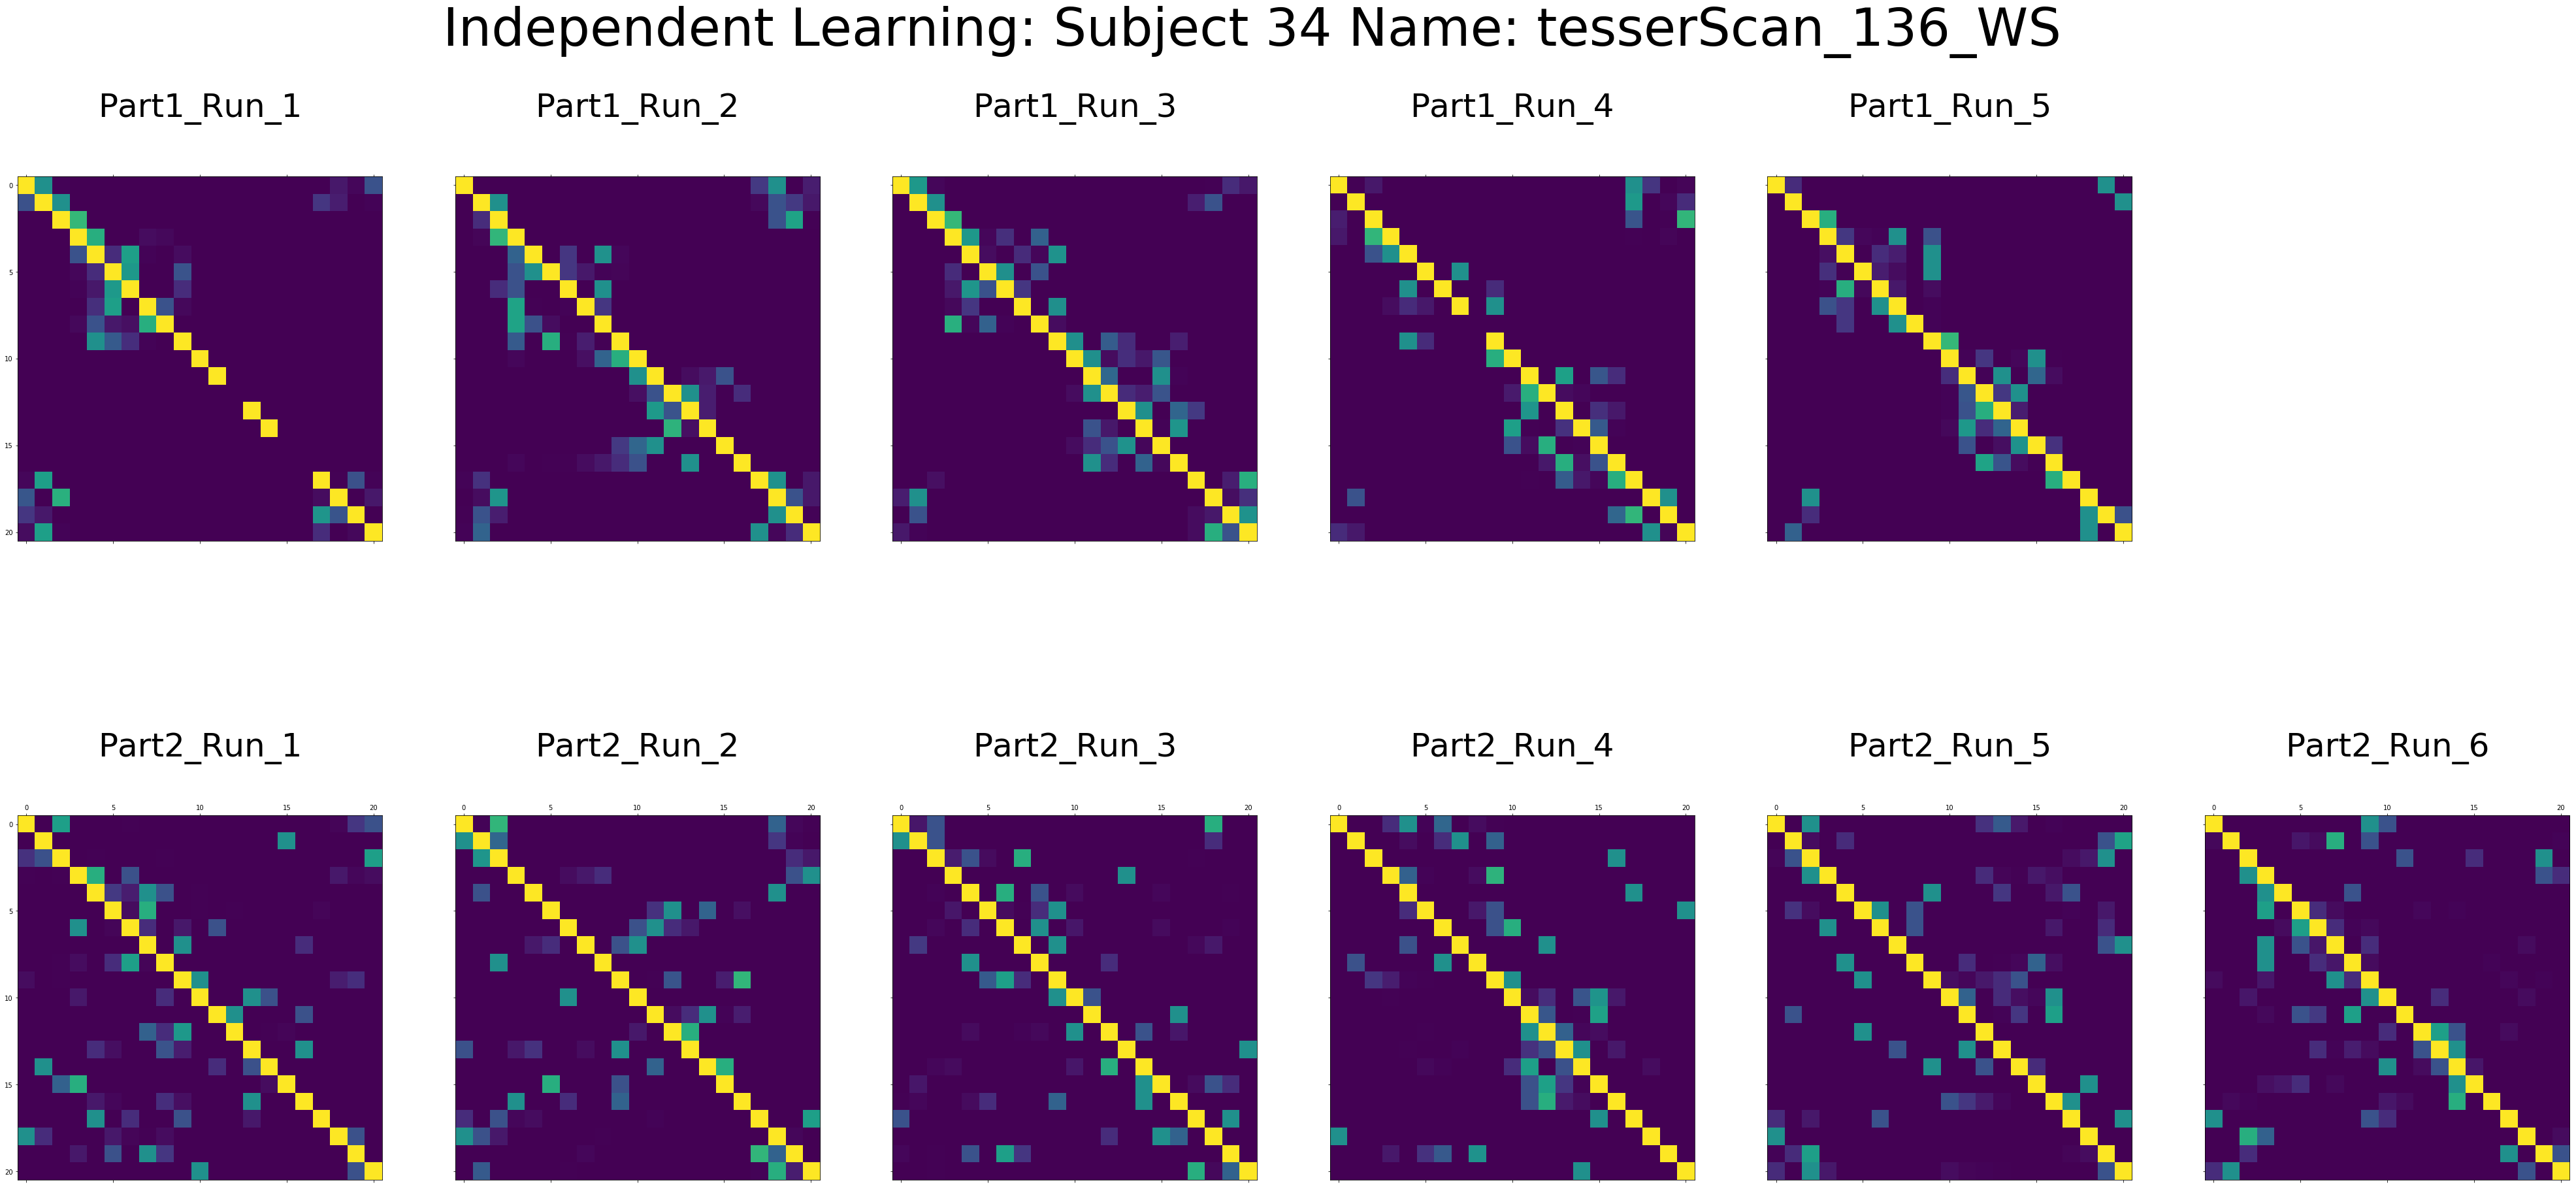

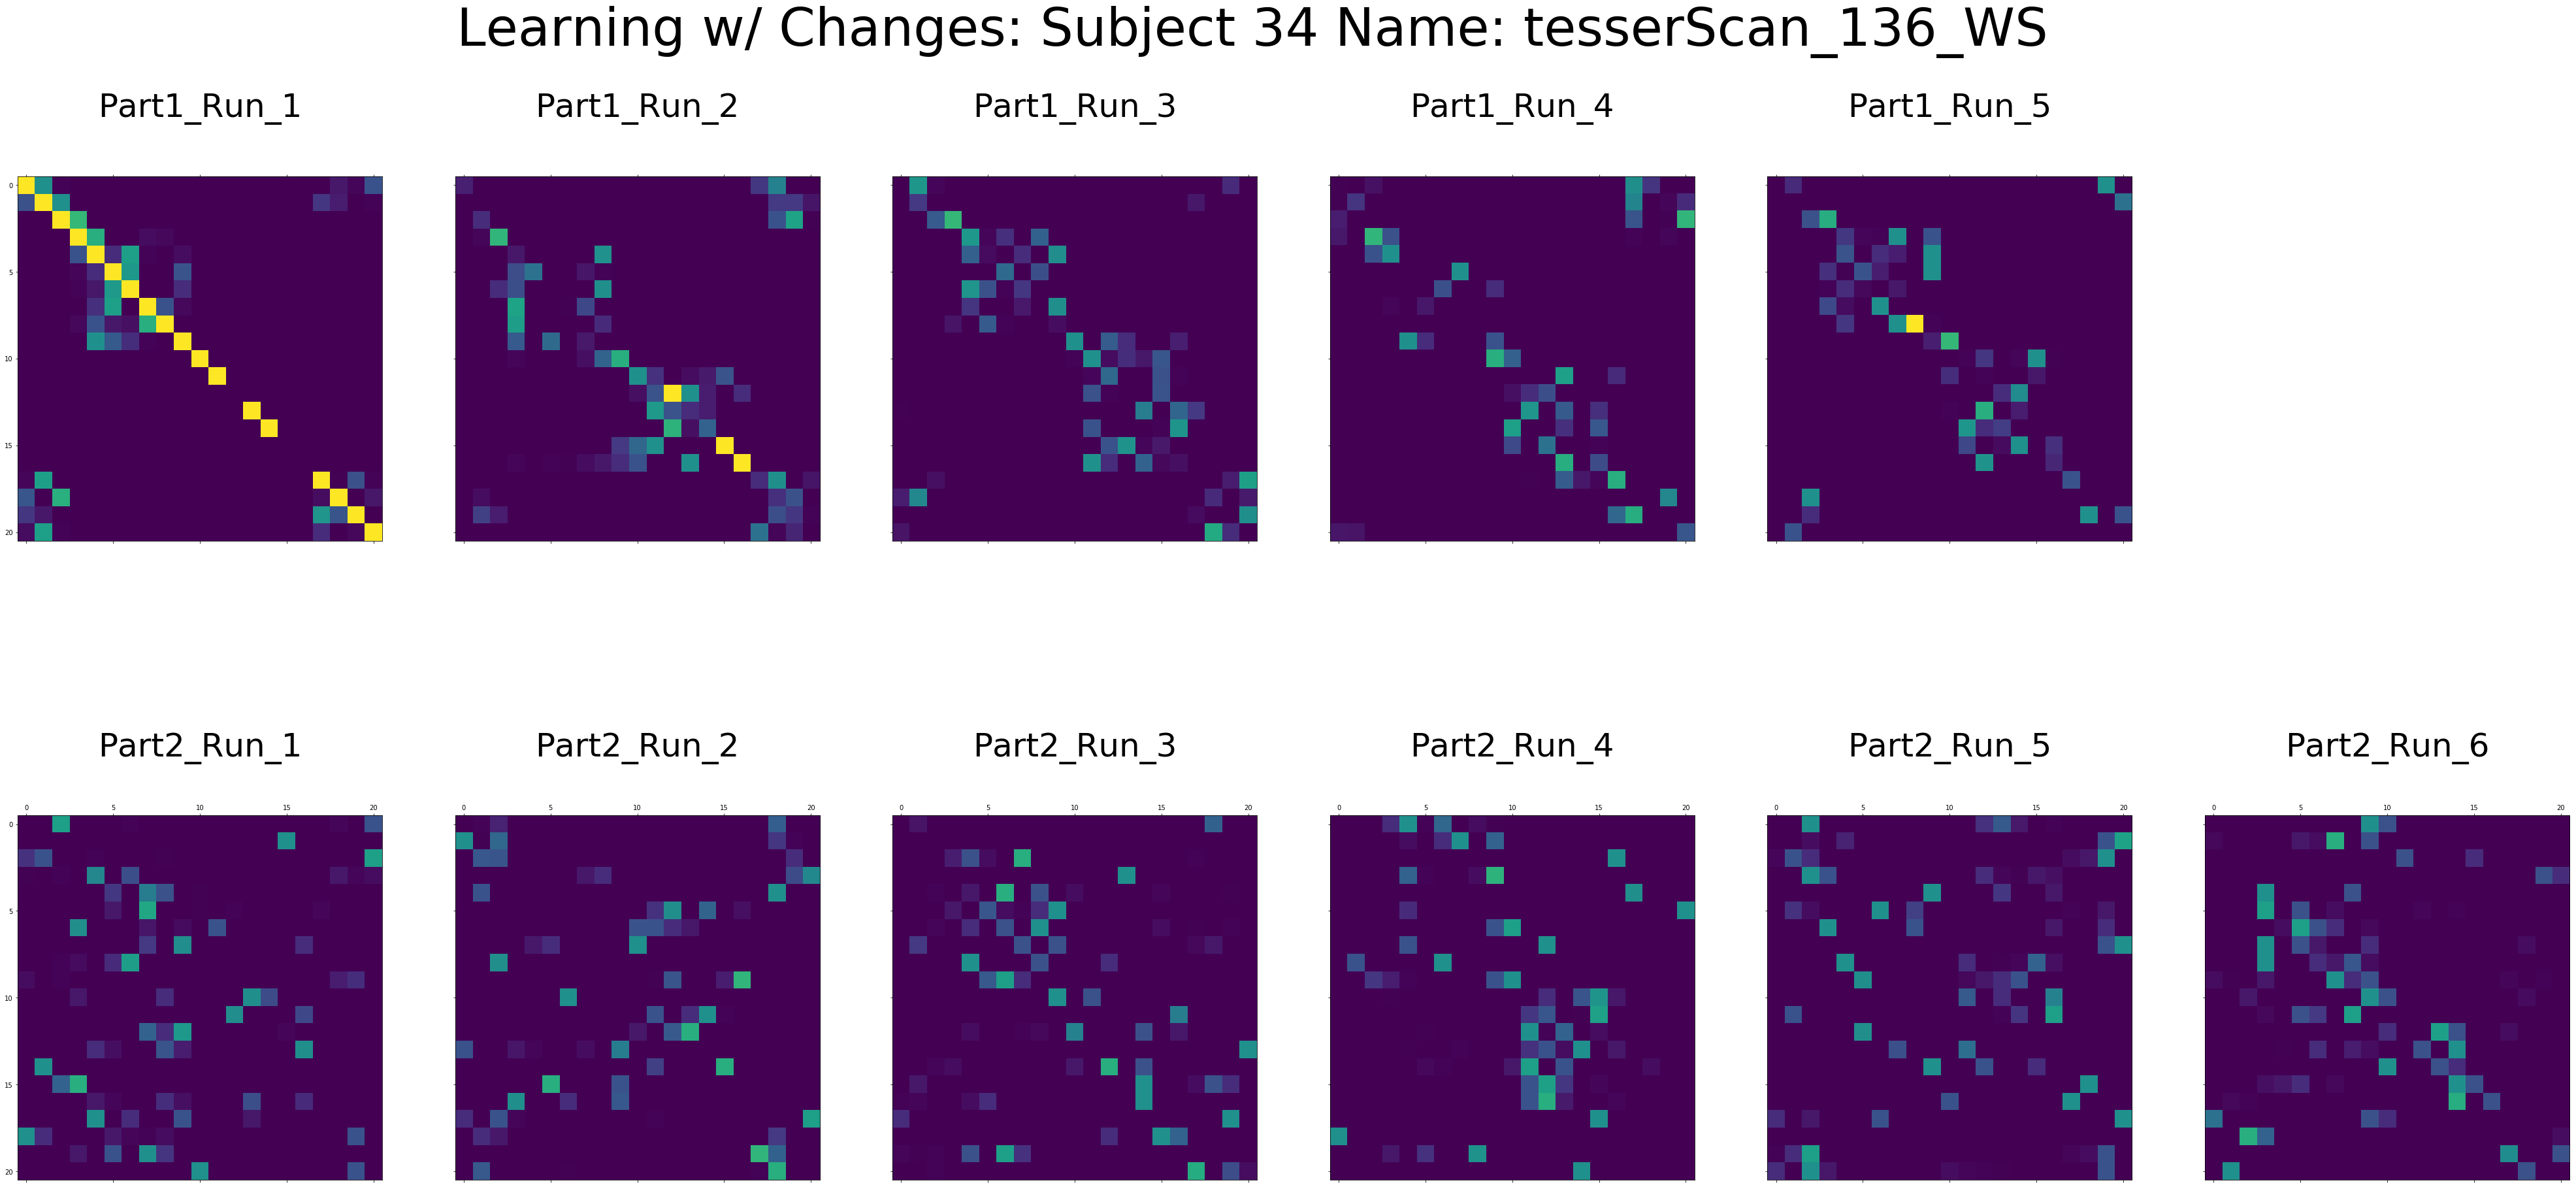

In [5]:
def indiv(subject_number, gamma, alpha):
    i = subject_number
    main_opt('persist', i,gamma, alpha)
    main_opt('reset', i,gamma, alpha)
    main_opt('independent', i,gamma, alpha)
    main_opt('track changes', i, gamma, alpha)
# for i in range(0,(len(dl)//11)):
indiv(34, 0.5, 1)

In [6]:

def make_rdm(subj_num, a,gamma, alpha):
    envsteps = ln.make_envstep(a)
    M = ln.SRclass_nathum_exp1(envsteps, gamma, alpha, 0.5)
    rdm = spsd.squareform(spsd.pdist(M, 'correlation'))
    return rdm


def track_alpha_change(subj_num):

    a = initial_subj_run(subj_num)
    fig, axs = plt.subplots(2,5, figsize=(20,10))
    plt.suptitle("Trancking RDM with " r'$\alpha$ change 0 to 1: ' + dl[a][:17]  + "  Subject " + dl[a][11:14] + " Part 1 Run 5""\n", 
                 fontweight="bold", size = (20), ha = 'center')
    for ax,count,i in zip(axs.flat, range(10, 110, 10),range(0,10)):
        alpha = count/100
        x = make_rdm(subj_num, a + i ,0.5, alpha)
        im = ax.matshow(x, cmap='viridis', vmin=-.1, vmax=.1)
        ax.set_title("Alpha = " + str(alpha),y=1.10)

    cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink = .85)
    cbar.set_label('Color Bar')


In [7]:
def my_function(dic):
    for x in range(len(dic)):
        if len(dic[x]) == 0:
            del dic[x]
        else:
            continue
    return dic

def missing_obj():

    # loops over every data set
    index = []
    t = {}
    for i in range(0,len(dl)):

        l = list(range(1,22))
        read_data = data[dl[i]][" objnum"]
        j = []
        g = []
        e = {}
        # loops over every trial to create a searchable list
        for k in range(0,len(read_data)):
            n = int(read_data[k])
            j.append(n)
        count = 0
        # loops over every objnum and sees if it is in the data set
        for h in range(0,len(l)):

            if l[h] not in j:

                index.append(i)
                m = n + count
                g.append(m)

#                 print("Subject " + dl[i][11:14] + " is missing object " + str(m) + 
#                   " in "+ "Part " + dl[i][-11] + " and Run: " + dl[i][-5])
                count +=1
                

            else:
                continue
            
        t.update({i:g})

    my_list= my_function(t)
    new_list =list(my_list.keys())
    for f in new_list:
        d = my_list[f]
        s = (17 - len(str(d))) *' '
        print("Subject " + dl[f][11:14] + " is missing object/s "+ str(d) + s +
              " from " + "Part " + dl[f][-11] + " and Run: " + dl[f][-5] + "         Directory #" +str(f))

missing_obj()


Subject 100 is missing object/s [2]               from Part 1 and Run: 1         Directory #0
Subject 101 is missing object/s [10]              from Part 1 and Run: 3         Directory #13
Subject 103 is missing object/s [13, 14, 15]      from Part 1 and Run: 4         Directory #36
Subject 104 is missing object/s [8]               from Part 1 and Run: 2         Directory #45
Subject 108 is missing object/s [5, 6]            from Part 1 and Run: 2         Directory #89
Subject 108 is missing object/s [6, 7, 8]         from Part 1 and Run: 4         Directory #91
Subject 112 is missing object/s [13, 14, 15, 16]  from Part 1 and Run: 4         Directory #135
Subject 112 is missing object/s [1]               from Part 2 and Run: 3         Directory #139
Subject 113 is missing object/s [7, 8, 9, 10]     from Part 1 and Run: 4         Directory #146
Subject 115 is missing object/s [17]              from Part 1 and Run: 4         Directory #168
Subject 116 is missing object/s [20, 21]       

In [8]:
def track_alpha_with_learning_rmd_change(subj_num,gamma,alpha_min ,alpha_max ,step):

	for x in np.arange(alpha_min, alpha_max, step):
		gamma = np.round(gamma,decimals=2)
		alpha = np.round(x,decimals=2)
		r = 7.5
		c = 5
		M = np.zeros([21,21])  
		a = initial_subj_run(subj_num)

		fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(r, c))
		plt.suptitle("Trancking RDM with Learning and " r"$\alpha$ "" Change " + "\n"
					 + "Subject Number: " + str(subj_num) +" Subject Name: " + dl[a][:17] + "  "r'$\alpha$ : ' + str(alpha) + "\n", 
				 fontweight="bold", size = (10), ha = 'center',y=1.10)
		plt.subplots_adjust(hspace=1)
		title_1 = " Part_" + str(1)#dl[a][:17] + " Part_" + str(1)

		for run in [0,1,2,3,4]:
			if run < 3:
				row = 0
				ax = axes[row,run]
				envsteps = ln.make_envstep(a + run)
				M_new = np.copy(M)
				M_new = fix(ln.SRclass_nathum_exp1(envsteps, gamma, alpha, np.copy(M)))
				rdm = spsd.squareform(spsd.pdist(M_new, 'correlation'))
				ax.set_title(title_1 + " Run_" + dl[a + run][-5] + "\n")
				im = ax.imshow(rdm, cmap='viridis', vmin=0, vmax=1)
				M = M_new

			if run > 2:
				row = 1
				run2 = run - 3
				ax = axes[row,run2]
				envsteps = ln.make_envstep(a + run)
				M_new = np.copy(M)
				M_new = fix(ln.SRclass_nathum_exp1(envsteps, gamma, alpha, np.copy(M)))
				ax.set_title(title_1 + " Run_" + dl[a + run][-5] + "\n")
				rdm = spsd.squareform(spsd.pdist(M_new, 'correlation'))
				im = ax.imshow(rdm, cmap='viridis', vmin=0, vmax=1)
				M = M_new
                
			if run == 4:
				fig.delaxes(axes[1][2])

		cbar = fig.colorbar(im, ax=axes.ravel().tolist())
		cbar.set_label('Color Bar')
       
	return plt.show()

In [8]:
# track_alpha_with_learning_rmd_change(subj_num = 18, gamma = 0.5,alpha_min = 0.1,alpha_max=0.4,step=0.01)

In [52]:
def repeat(subj_num, gamma, alpha):
    a = initial_subj_run(subj_num)
    M = np.zeros([21,21])
    for time in [1]:
        for run in range(0,11):
            envstep = ln.make_envstep (a + run)
            M = np.array (ln.SRclass_nathum_exp1 (envstep, gamma, alpha, np.copy(M)))
    return M


nodes = network.node_info()
adjacency = network.adjacency (nodes)
transition = adjacency / 6

def compute_limit_matrix (gamma):
    num_states = 21
    identity = np.eye (num_states)
    return np.linalg.inv (identity - gamma*adjacency/6)

def rda (matrix):
    return spsd.squareform (spsd.pdist (matrix, 'correlation'))

def correlate_rows (matrix):
    return np.dot(matrix, matrix.T) / (la.norm (matrix)**2)

def correlate_columns (matrix):
    return np.dot(matrix.T, matrix) / (la.norm (matrix)**2)
    

def rain(option, subj_num, gamma, alpha):
    L = compute_limit_matrix (.5)
    L_vector = L.flatten()
    M = repeat(subj_num, gamma, alpha)
    M_vector = M.flatten()
#     plt.matshow (M, vmin = 0, vmax = .5)
#     plt.colorbar()
    
    if option == 'norm':
        opt = la.norm(L_vector - M_vector, np.inf)
        print ('Norm of L - M: ')
        print (opt)
    
    if option == 'correlation':
        opt = np.dot (L_vector, M_vector) / (la.norm (L_vector) * la.norm (M_vector))
#         print ('Correlation of L, M: ')
#         print (opt)

#     plt.matshow (L, vmin = 0, vmax = .5)
#     plt.colorbar()
    return opt

In [53]:
new_data = [[],[]]
for alpha in np.arange(0.00, 0.90, 0.01):
    new_data[0].append(alpha)
    new_data[1].append(rain ('correlation', 1,0.5, alpha))


/home/rodrigo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


(0.33, 0.9633340353365724)

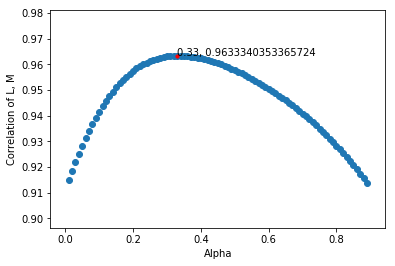

In [54]:
plt.scatter(new_data[0],new_data[1])
s = new_data[1]                  
sort_index = np.argsort(s)

max_vals_alpha = new_data[0][sort_index[-2]]
max_vals_corr  = new_data[1][sort_index[-2]]
plt.scatter(max_vals_alpha, max_vals_corr, c='red',s=10)
plt.annotate(str(max_vals_alpha)+", "+str(max_vals_corr), (max_vals_alpha, max_vals_corr))
plt.xlabel('Alpha')
plt.ylabel('Correlation of L, M')
max_vals_alpha, max_vals_corr

In [55]:
alpha_data = np.array(new_data[0])
corr_data = np.array(new_data[1])
ploting_data= {'alpha': alpha_data, 'correlation data':corr_data }
df = pd.DataFrame(data = ploting_data)

In [56]:
max = [[],[]]
for n in range(1,len(corr_data) - 1):
    if  corr_data[n] > corr_data[n - 1]:
        max[0].append(corr_data[n])
        max[1].append(n)
    else:
        continue
max.sort()
max_val = max[0][-1]
max_index = max[1][-1]

print(max_val, corr_data[max_index], alpha_data[max_index])

0.9633340353365724 0.9633340353365724 0.33


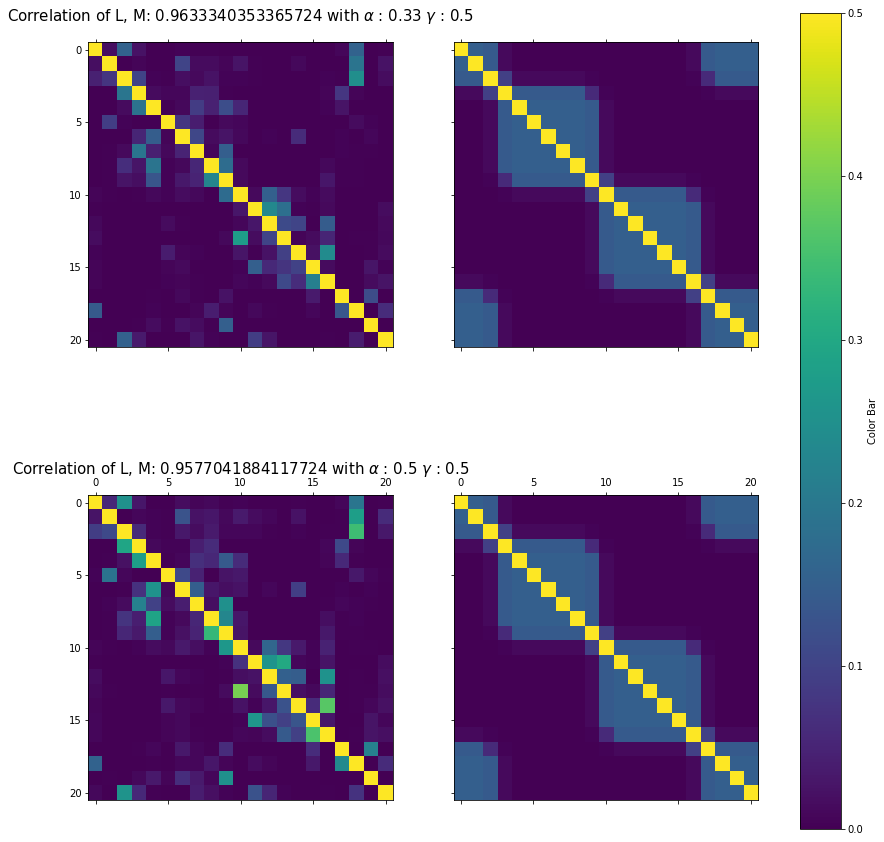

In [57]:
min_val = corr_data[-1]
max_alpha = np.around(alpha_data[max_index], decimals=2)
min_alpha = np.around(.5, decimals=2)

figsize=(15,15)
figure, axes_corr = plt.subplots(nrows=2, ncols=2,figsize=figsize ,sharex='col', sharey='row')
plt.subplots_adjust(hspace=0.25)
for a,count in zip([max_alpha, min_alpha], [0,1]):
    L = compute_limit_matrix (.5)
    L_vector = L.flatten()
    M = repeat(subj_num =1, gamma=0.5, alpha = a)
    M_vector = M.flatten()
    img = axes_corr[count,0].matshow (M, vmin = 0, vmax = .5)



    opt = np.dot (L_vector, M_vector) / (la.norm (L_vector) * la.norm (M_vector))


    img = axes_corr[count,1].matshow (L, vmin = 0, vmax = .5)
    axes_corr[count,0].set_title('Correlation of L, M: '+ str(opt)+" with "r'$\alpha$ : '+str(a)+" "r'$\gamma$ : '+str(0.5), size = 15)
cbar = figure.colorbar(img, ax =axes_corr.ravel().tolist())
cbar.set_label('Color Bar')